# APOGEE Raw Selection Function Tutorial

Welcome to Tutorial 1 of how to use the APOGEE Selection Function! This jupyter notebook will walk you through the basic usage of the APOGEE Raw (2D) Selection Function using the pre-computed selection function for DR-17.

More detail can be found here: https://github.com/astrojimig/precalculated-dr17-selfunc

If you have any questions, please email me at jimig@nmsu.edu

### The selection function only applies to "main sample" APOGEE targets - the stars that were targeted randomly from the 2MASS catalog.

Any ancillary program targets - i.e (dwarf galaxy targets, star cluster members, overlap observations with Kepler) - should NOT be used with this selection fucntion because it is not an accurate representation of their selection fraction.

+ An easy way to filter these is to use the `EXTRATARG` column in the allstar file. `allstar['EXTRATARG'] == 0'` returns main survey targets.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import dill as pickle
import astropy.io.fits as fits

#Define some environment variables/paths
os.environ['RESULTS_VERS'] = 'dr17'
os.environ['SDSS_LOCAL_SAS_MIRROR'] = '/Users/julieimig/research/APOGEE/'

#The DR17 Selection Function Code
#https://github.com/astrojimig/apogee/tree/dr17-selection
sys.path.insert(1, '/Users/julieimig/research/APOGEE/sandbox/apogee/')

import apogee.select as apsel
import apogee.tools.read as apread


/Users/julieimig/anaconda3/lib/python3.6/site-packages/galpy-1.7.0.dev0-py3.6.egg/galpy/util/bovy_plot.py:5: FutureWarning: galpy.util.bovy_plot is being deprecated in favor of galpy.util.plot; functions inside of this module have also changed name, but all functions still exist; please switch to the new import and new function names, because the old import and function names will be removed in v1.9
  warnings.warn('galpy.util.bovy_plot is being deprecated in favor of galpy.util.plot; functions inside of this module have also changed name, but all functions still exist; please switch to the new import and new function names, because the old import and function names will be removed in v1.9',FutureWarning)

/Users/julieimig/anaconda3/lib/python3.6/site-packages/galpy-1.7.0.dev0-py3.6.egg/galpy/util/bovy_coords.py:6: FutureWarning: galpy.util.bovy_coords is being deprecated in favor of galpy.util.coords; all functions in there are the same; please switch to the new import, because the ol

In [2]:
#Define Plotting Parameters
params = {'axes.labelsize': 36, 'xtick.labelsize': 36, 'ytick.labelsize': 36, 
          'text.usetex': False, 'lines.linewidth': 1,
          'axes.titlesize': 22, 'font.family': 'serif', 'font.size': 36}
plt.rcParams.update(params)


# Load in the allStar file

In [3]:
#Change this path as relevant
allstarpath = os.environ['SDSS_LOCAL_SAS_MIRROR'] + 'dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits'
#Load in the allStar file
allstar = fits.open(allstarpath)[1].data

# Load in the Raw Selection Function

In [4]:
apogee_selfunc = pickle.load(open('sav/apogeeCombinedSF.dat', 'rb'))

# ...OR calculate the Selection Function Yourself

The following bit of code will compute the APOGEE selection function from scratch using the APOGEE code repository:
- https://github.com/jobovy/apogee
- https://github.com/astrojimig/apogee/tree/dr17-selection (updated for DR17 - still in final testing!)

This takes several hours (on a single core), and will download all of the targeting files to your 'SDSS_LOCAL_SAS_MIRROR' during the process (more than 38 GB of data!). If you downloaded the pre-computed selection function with this tutorial, you do not need to do this step, which is why it is commented out!

In [5]:
#allstar = apread.allStar(main=True, rmdups=True)
#apogee_selfunc = apsel.apogeeCombinedSelect(year=10)
#    
#with open('sav/apogeeCombinedSF.dat', 'wb') as f:
#    pickle.dump(apogee_selfunc, f)

# Basic Use: Retrieving a Selection Fraction

The APOGEE Raw Selection Function depends on field (location), cohort (apparent H magnitude), and color (J-K) based on the targeting strategies. If provided with those 3 things, the selection funciton will return the selection fraction for that star.

In [6]:
#Pick a Random Star to test
i = 1000

apogeeid = allstar['APOGEE_ID'][i]
location = allstar['LOCATION_ID'][i]
Hmag = allstar['H'][i]
JK = allstar['J'][i] - allstar['K'][i]

print('APOGEE_ID: {} i={}\nLocation ID: {}\nHmag apparent magnitude: {}\n(J-K) color: {}'.format(apogeeid, i, location, Hmag, JK))

APOGEE_ID: 2M00040522+5703320 i=1000
Location ID: 5922
Hmag apparent magnitude: 12.574000358581543
(J-K) color: 0.7860002517700195


In [7]:
#Retrieve the Selection Fraction!
selection_fraction = apogee_selfunc(location, Hmag, JK)

print('{}\nSelection Fraction: {}'.format(apogeeid,selection_fraction))

2M00040522+5703320
Selection Fraction: 0.09714285714285714


The `apogee_selfunc(location, Hmag, JK)` function returns the main quantity (the selection fraction) for the raw selection function!

The example for star 2M00040522+5703320 (i=1000) returns a selection fraction of 0.097, meaning that star had a 9.7% chance of being targeted by APOGEE.

In [8]:
#List of all locations
apogee_selfunc._locations

array([4102, 4103, 4105, ..., 6141, 6142, 6143], dtype=int16)

# Basic Use 2: Return the targeting parameters for a given Location ID

The targeting parameters can vary between each location, so it may be useful to retrieve the exact cuts for a given field as needed. Each field is split into up to three **cohorts** (short, medium, and long) defined by boundaries in apparent H magnitude, and different **color bins** depending on the survey and location in the Galaxy. 

- APOGEE-1 used a flat color cut of (J-K) > 0.5
- APOGEE-2 used two color cuts of (J-K) > 0.5 and (J-K) > 0.8 for fields in the disk
- APOGEE-2 used two color cuts of (J-K) > 0.3 for halo fields

The raw selection fraction is calculated for each combination of cohort and color bin as needed by the targeting strategy for a given field.

More targeting Information can be found here:
https://www.sdss4.org/dr17/irspec/targets/


In [9]:
#Pick a random location
i = 1000
loc = apogee_selfunc._locations[i]
print('-'*50)
print('Location ID: ' + str(loc))

#Hmin and Hmax (apparent magnitude) defining a cohort for a specific location
print('Hmax: ' + str(apogee_selfunc.Hmax(loc)))
print('Hmin: ' + str(apogee_selfunc.Hmin(loc)))

#Color bins defining a cohort for a specific location
print('NColorBins: ' + str(apogee_selfunc.NColorBins(loc)))
print('(J-K) min: ' + str(apogee_selfunc.JKmin(loc)))
print('(J-K) max: ' + str(apogee_selfunc.JKmax(loc)))

#Number of Spectroscopic targets (observations) in a field
print('Number of Spectroscopic Targets (observations): ' + str(apogee_selfunc._nspec_short[i]))

#Number of photometric targets (all possible targets / 2MASS catalog ) in a field
print('Number of Photometric Targets (2MASS): ' + str(apogee_selfunc._nphot_short[i]))

print('-'*50)
print('Selection Fraction: ' + str(apogee_selfunc._nspec_short[i]/apogee_selfunc._nphot_short[i]))
print('-'*50)


--------------------------------------------------
Location ID: 5132
Hmax: [12.19999981]
Hmin: [7.]
NColorBins: 1
(J-K) min: 0.5
(J-K) max: 999.0
Number of Spectroscopic Targets (observations): [448.  nan  nan  nan  nan]
Number of Photometric Targets (2MASS): [16478.    nan    nan    nan    nan]
--------------------------------------------------
Selection Fraction: [0.02718777        nan        nan        nan        nan]
--------------------------------------------------


# Plot 1: the Raw Selection Function of the Short Cohort

In [10]:
#Coordinates from the Selection Function
aposel_glons = np.array([apogee_selfunc.glonGlat(x)[0][0] for x in apogee_selfunc._locations])
aposel_glats = np.array([apogee_selfunc.glonGlat(x)[1][0] for x in apogee_selfunc._locations])

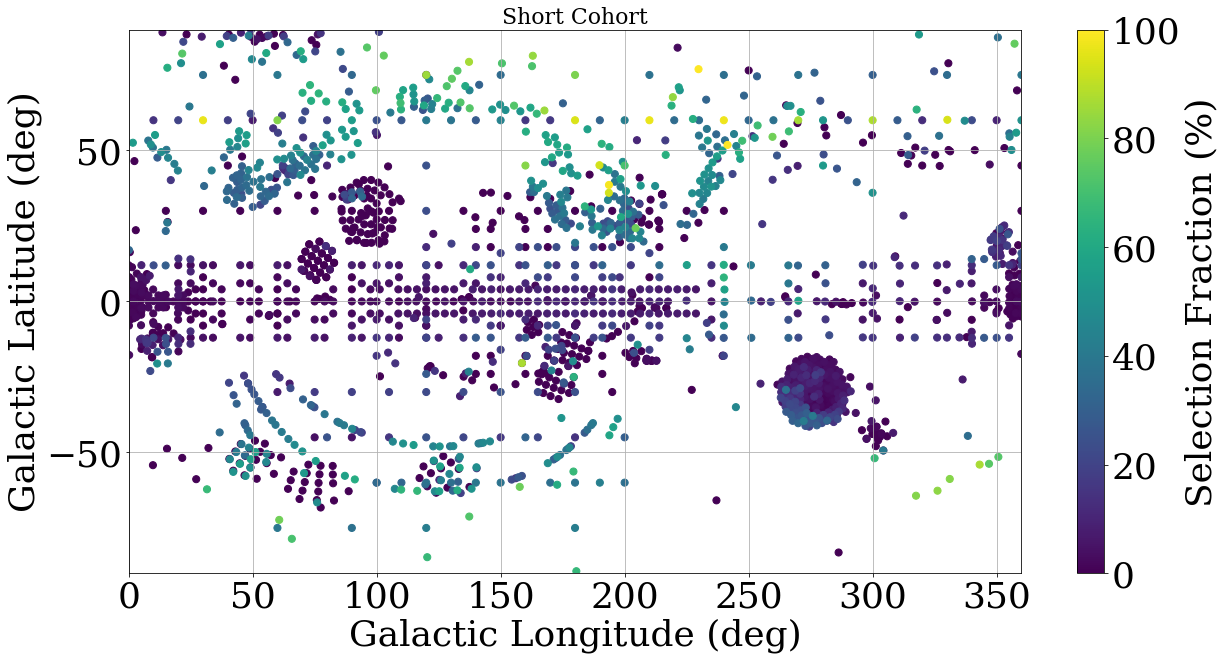

In [11]:
sel_fractions = (apogee_selfunc._nspec_short/apogee_selfunc._nphot_short).T[0]*100

plt.figure(figsize=(20,10))
idx = np.argsort(sel_fractions)
plt.scatter(aposel_glons[idx],aposel_glats[idx],
            c=sel_fractions[idx],vmin=0,vmax=100,cmap='viridis',
            s=50)

plt.colorbar(label='Selection Fraction (%)')
plt.title('Short Cohort')
plt.grid()
plt.xlim(0,360)
plt.ylim(-90,90)
plt.xlabel('Galactic Longitude (deg)')
plt.ylabel('Galactic Latitude (deg)')

plt.show()

# Plot 2: the Selection Fraction as a Function of cohort and color bin
 This is slightly more representative of the targeting strategies of APOGEE and thus the "true" raw selection function, but much more confusing of a plot!

/Users/julieimig/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide



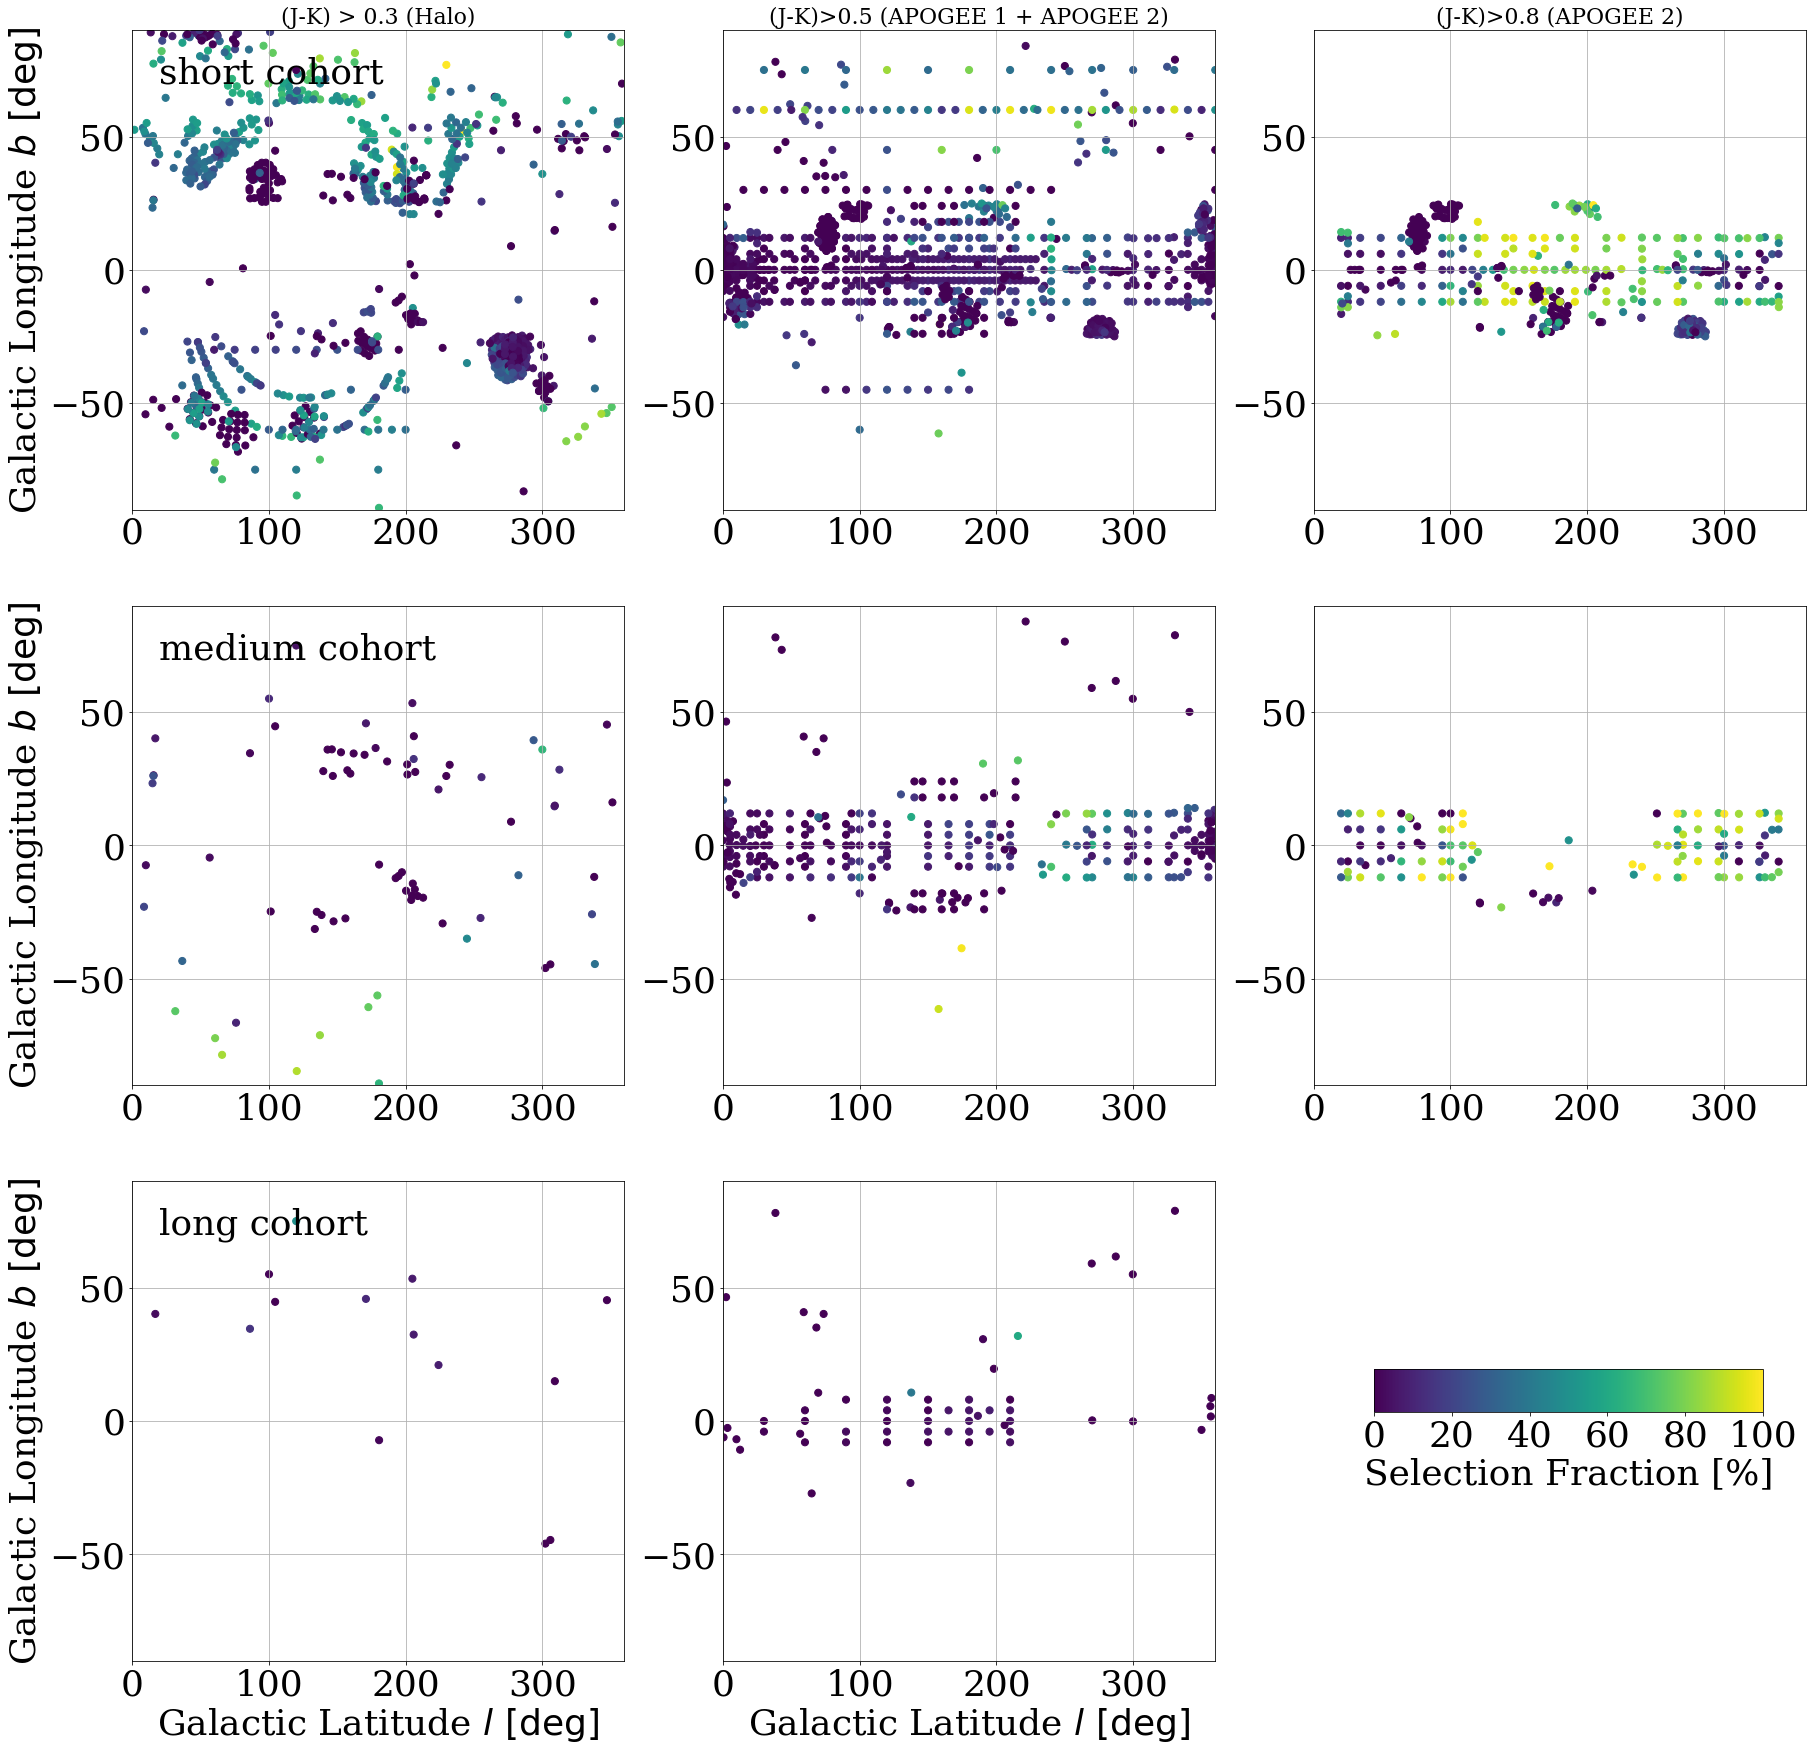

In [12]:
#Set up Figure
fig = plt.figure(figsize=(30,30))
xlabel = r'Galactic Latitude $l\ \mathrm{[deg]}$'
ylabel = r'Galactic Longitude $b\ \mathrm{[deg]}$'
anno_x, anno_y = 210,-70
#fig.set_size_inches(20,20)

def plot_selfunc_grid(cohort,colorbin):
    mask3 = []
    mask5 = []
    mask8 = []
    for l in apogee_selfunc._locations:
        if round(apogee_selfunc.JKmax(l),2) == 0.8:
            mask8.append(True)
        else:
            mask8.append(False)
            
        if round(apogee_selfunc.JKmin(l),2) == 0.3:
            mask3.append(True)
        else:
            mask3.append(False)
            
        if round(apogee_selfunc.JKmin(l),2) == 0.5:
            mask5.append(True)
        else:
            mask5.append(False)
                
    if cohort == 'short':
        sel_fractions = (apogee_selfunc._nspec_short/apogee_selfunc._nphot_short)
        
    if cohort == 'medium':
        sel_fractions = (apogee_selfunc._nspec_medium/apogee_selfunc._nphot_medium)
        
    if cohort == 'long':
        sel_fractions = (apogee_selfunc._nspec_long/apogee_selfunc._nphot_long)
        
    if colorbin == 0.3:
        sel_fractions = sel_fractions.T[0]*100
        m = mask3

    elif colorbin == 0.5:
        sel_fractions = sel_fractions.T[0]*100
        m = mask5
        
    elif colorbin == 0.8:
        sel_fractions = sel_fractions.T[1]*100
        m = mask8
        
    plt.grid()
    plt.xlim(0,360)
    plt.ylim(-90,90)
    plt.scatter(aposel_glons[m],aposel_glats[m],c=sel_fractions[m],vmin=0,vmax=100,cmap='viridis', s=50)
    return

    
plt.subplot(3,3,1)
plt.title('(J-K) > 0.3 (Halo)')
plot_selfunc_grid('short',0.3)
plt.ylabel(ylabel)
plt.text(20,70, 'short cohort')

plt.subplot(3,3,2)
#Short Cohort, (J-K)>0.5
plt.title('(J-K)>0.5 (APOGEE 1 + APOGEE 2)')
plot_selfunc_grid('short',0.5)

plt.subplot(3,3,3)
#Short Cohort, (J-K)>0.8
plt.title('(J-K)>0.8 (APOGEE 2)')
plot_selfunc_grid('short',0.8)


plt.subplot(3,3,4)
#Medium Cohort,(J-K)>0.3
plot_selfunc_grid('medium',0.3)
plt.ylabel(ylabel)
plt.text(20,70, 'medium cohort')


plt.subplot(3,3,5)
#Medium Cohort,(J-K)>0.5
plot_selfunc_grid('medium',0.5)

plt.subplot(3,3,6)
#Medium Cohort,(J-K)>0.8
plot_selfunc_grid('medium',0.8)

plt.subplot(3,3,7)
#Long Cohort, (J-K)>0.3
plot_selfunc_grid('long',0.3)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.text(20,70, 'long cohort')


plt.subplot(3,3,8)
#Long Cohort, (J-K)>0.5
plot_selfunc_grid('long',0.5)
plt.xlabel(xlabel)

cax = fig.add_axes([0.7,0.24,0.18,0.02])
plt.colorbar(cax=cax, orientation='horizontal', label=r'Selection Fraction [%]')

plt.show()
